In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [27]:
# Load the dataset
data = load_diabetes()
X = data.data
y = data.target

In [28]:
# Initial split to separate out the test set (e.g., 20% of the data)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the remaining data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
# Note: 0.25 * 0.8 = 0.2, so the validation set is 20% of the original data.

# Standardize the features using the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)          # Only transform on validation data
X_test = scaler.transform(X_test)        # Only transform on test data

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [41]:
# 2. Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.layer2(out)
        return out

model = DiabetesModel()

In [42]:
# 3. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop with training and validation loss tracking
num_epochs = 1000

# Define lists to store training and validation losses
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print losses every few epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Training Loss: {epoch_train_loss:.4f} '
              f'Validation Loss: {epoch_val_loss:.4f}')



Epoch [1/1000] Training Loss: 29659.8029 Validation Loss: 26455.5585
Epoch [10/1000] Training Loss: 28681.4560 Validation Loss: 25527.5321
Epoch [20/1000] Training Loss: 25882.9360 Validation Loss: 22951.8556
Epoch [30/1000] Training Loss: 20646.8100 Validation Loss: 18209.3439
Epoch [40/1000] Training Loss: 14363.3846 Validation Loss: 12648.0963
Epoch [50/1000] Training Loss: 9830.6455 Validation Loss: 8649.3823
Epoch [60/1000] Training Loss: 7429.8490 Validation Loss: 6608.2050
Epoch [70/1000] Training Loss: 6149.9999 Validation Loss: 5574.9976
Epoch [80/1000] Training Loss: 5407.5986 Validation Loss: 5037.4987
Epoch [90/1000] Training Loss: 4891.2337 Validation Loss: 4669.9193
Epoch [100/1000] Training Loss: 4539.2473 Validation Loss: 4471.1925
Epoch [110/1000] Training Loss: 4258.7970 Validation Loss: 4288.9530
Epoch [120/1000] Training Loss: 4049.3936 Validation Loss: 4125.7949
Epoch [130/1000] Training Loss: 3853.8521 Validation Loss: 3990.9776
Epoch [140/1000] Training Loss: 369

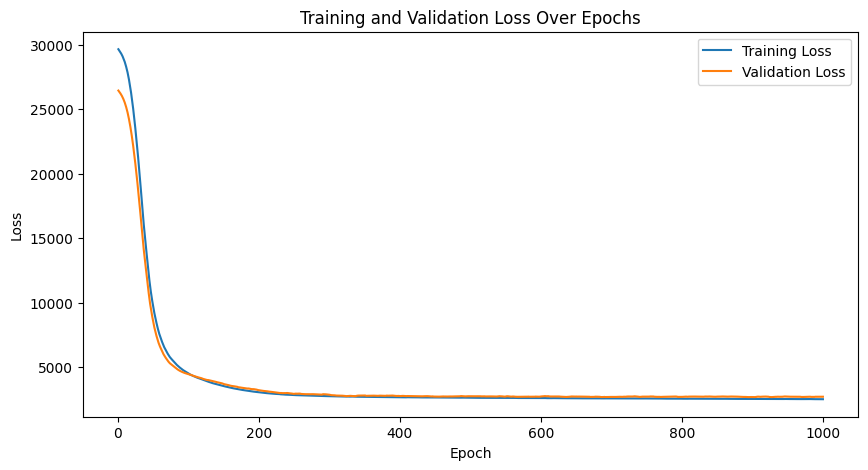

In [43]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()